In [0]:
import requests
import pandas as pd
import math

import json
from functools import reduce

# Matplotlib for visualization at the end
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import col, when, sum, when,lit, udf, to_timestamp, year, month, hour, dayofmonth

from pyspark.sql.types import StructType, StructField, StringType, DoubleType

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

## Grouping the features 

In [0]:
wind = ["wind_speed_10m", "wind_speed_120m", "wind_direction_10m", "wind_direction_120m", "wind_gusts_10m"]

cloud_cover = ["cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "visibility"]

# realtive_humidity_2m: is the ratio of the actual water vapor in the air to the maximum the air can hold at that temperature (in %)
# dew_point_2m: temperature at which air becomes saturated with moisture
# vapour_pressure_deficit: difference between the amount of moisture in the air and how much it can hold when saturated.

temperature = ["apparent_temperature", "temperature_2m", "temperature_120m", "relative_humidity_2m", "dew_point_2m", "vapour_pressure_deficit"]

rain_snow = ["precipitation_probability", "precipitation", "rain", "showers", "snowfall", "snow_depth"]

pressure = ["surface_pressure", "pressure_msl"]

water_balance = ["evapotranspiration", "et0_fao_evapotranspiration"]


## Loading the data

In [0]:
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"

dfs={}

# create pandas dataframes with the different types of features
# after transform the pandas data frane into a spark data frame

features = {
    'wind': wind, 
    'cloud_cover': cloud_cover, 
    'temperature': temperature, 
    'rain_snow': rain_snow,
    'pressure': pressure, 
    'water_balance': water_balance
    }

for key, value in features.items():
	params = {
		# Lisbon coordinates
		"latitude": 38.716885,
		"longitude": -9.140233,
		# 1 Year Historical data
		"start_date": "2023-05-01",
		"end_date": "2025-05-01",
		"hourly": value
	}

	response = requests.get(url, params=params)
	data = response.json()
	print(key)
	pdf = pd.DataFrame(data['hourly'])
	dfs[key] = spark.createDataFrame(pdf)

wind
cloud_cover
temperature
rain_snow
pressure
water_balance


In [0]:
dfs

Out[4]: {'wind': DataFrame[time: string, wind_speed_10m: double, wind_speed_120m: double, wind_direction_10m: bigint, wind_direction_120m: bigint, wind_gusts_10m: double],
 'cloud_cover': DataFrame[time: string, cloud_cover: bigint, cloud_cover_low: bigint, cloud_cover_mid: bigint, cloud_cover_high: bigint, visibility: double],
 'temperature': DataFrame[time: string, apparent_temperature: double, temperature_2m: double, temperature_120m: double, relative_humidity_2m: bigint, dew_point_2m: double, vapour_pressure_deficit: double],
 'rain_snow': DataFrame[time: string, precipitation_probability: void, precipitation: double, rain: double, showers: double, snowfall: double, snow_depth: double],
 'pressure': DataFrame[time: string, surface_pressure: double, pressure_msl: double],
 'water_balance': DataFrame[time: string, evapotranspiration: double, et0_fao_evapotranspiration: double]}

In [0]:
# columns on the wind df as an example
dfs['wind'].columns

Out[5]: ['time',
 'wind_speed_10m',
 'wind_speed_120m',
 'wind_direction_10m',
 'wind_direction_120m',
 'wind_gusts_10m']

In [0]:
# list of dataframes extracted from the dictionary
dfs_list = list(dfs.values())

# merge all DataFrames on the 'time' column with an outer join, reduce is used to simplify code
# so that we dont have to do all the joins one by one
sdf_merged = reduce(lambda left, right: left.join(right, on="time", how="outer"), dfs_list)


In [0]:
sdf_merged.printSchema()
display(sdf_merged.limit(10))

root
 |-- time: string (nullable = true)
 |-- wind_speed_10m: double (nullable = true)
 |-- wind_speed_120m: double (nullable = true)
 |-- wind_direction_10m: long (nullable = true)
 |-- wind_direction_120m: long (nullable = true)
 |-- wind_gusts_10m: double (nullable = true)
 |-- cloud_cover: long (nullable = true)
 |-- cloud_cover_low: long (nullable = true)
 |-- cloud_cover_mid: long (nullable = true)
 |-- cloud_cover_high: long (nullable = true)
 |-- visibility: double (nullable = true)
 |-- apparent_temperature: double (nullable = true)
 |-- temperature_2m: double (nullable = true)
 |-- temperature_120m: double (nullable = true)
 |-- relative_humidity_2m: long (nullable = true)
 |-- dew_point_2m: double (nullable = true)
 |-- vapour_pressure_deficit: double (nullable = true)
 |-- precipitation_probability: void (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- showers: double (nullable = true)
 |-- snowfall: double (nullable = 

time wind_speed_10m wind_speed_120m wind_direction_10m wind_direction_120m wind_gusts_10m cloud_cover cloud_cover_low cloud_cover_mid cloud_cover_high visibility apparent_temperature temperature_2m temperature_120m relative_humidity_2m dew_point_2m vapour_pressure_deficit precipitation_probability precipitation rain showers snowfall snow_depth surface_pressure pressure_msl evapotranspiration et0_fao_evapotranspiration 2023-05-01T00:00 6.2 21.4 21 7 18.0 0 0 0 0 24140.0 16.3 16.6 16.2 73 11.8 0.51 null 0.0 0.0 0.0 0.0 0.0 1014.5 1018.3 0.01 0.01 2023-05-01T01:00 4.5 19.8 14 2 13.0 0 0 0 0 24140.0 16.3 16.5 16.4 73 11.6 0.51 null 0.0 0.0 0.0 0.0 0.0 1014.2 1018.0 0.01 0.0 2023-05-01T02:00 3.0 18.8 346 355 10.4 0 0 0 0 24140.0 16.1 16.3 16.7 69 10.6 0.58 null 0.0 0.0 0.0 0.0 0.0 1013.7 1017.5 0.01 0.0 2023-05-01T03:00 3.2 18.8 360 357 6.8 100 0 0 100 24140.0 15.7 16.1 16.7 67 10.0 0.61 null 0.0 0.0 0.0 0.0 0.0 1013.7 1017.5 0.01 0.0 2023-05-01T04:00 3.0 17.7 346 355 5.8 42 0 0 42 24140.0 15.6 16.1 16.7 66 9.7 0.62 null 0.0 0.0 0.0 0.0 0.0 1014.0 1017.8 0.01 0.0 2023-05-01T05:00 3.6 19.4 6 360 8.3 96 0 0 96 24140.0 15.4 16.0 16.6 66 9.7 0.62 null 0.0 0.0 0.0 0.0 0.0 1014.0 1017.8 0.01 0.0 2023-05-01T06:00 3.4 16.7 32 6 9.0 29 0 0 29 24140.0 15.3 15.8 16.6 68 9.9 0.58 null 0.0 0.0 0.0 0.0 0.0 1013.9 1017.7 0.01 0.03 2023-05-01T07:00 3.3 14.5 41 14 7.2 0 0 0 0 24140.0 16.4 16.6 16.6 70 11.1 0.57 null 0.0 0.0 0.0 0.0 0.0 1014.0 1017.8 0.01 0.05 2023-05-01T08:00 5.0 11.7 21 18 14.4 0 0 0 0 24140.0 18.5 19.0 16.9 59 10.8 0.9 null 0.0 0.0 0.0 0.0 0.0 1014.4 1018.2 0.04 0.17 2023-05-01T09:00 7.0 9.2 21 21 19.4 0 0 0 0 24140.0 20.7 21.5 18.7 50 10.6 1.28 null 0.0 0.0 0.0 0.0 0.0 1014.5 1018.3 0.09 0.32

## Check for missing values

In [0]:
for group_feat in dfs.keys(): # check missing values
    dfs[group_feat].select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in dfs[group_feat].columns]).show()


+----+--------------+---------------+------------------+-------------------+--------------+
|time|wind_speed_10m|wind_speed_120m|wind_direction_10m|wind_direction_120m|wind_gusts_10m|
+----+--------------+---------------+------------------+-------------------+--------------+
|   0|             0|              0|                 0|                  0|             0|
+----+--------------+---------------+------------------+-------------------+--------------+

+----+-----------+---------------+---------------+----------------+----------+
|time|cloud_cover|cloud_cover_low|cloud_cover_mid|cloud_cover_high|visibility|
+----+-----------+---------------+---------------+----------------+----------+
|   0|          0|              0|              0|               0|         0|
+----+-----------+---------------+---------------+----------------+----------+

+----+--------------------+--------------+----------------+--------------------+------------+-----------------------+
|time|apparent_temperatur

In [0]:
sdf_merged.columns

Out[9]: ['time',
 'wind_speed_10m',
 'wind_speed_120m',
 'wind_direction_10m',
 'wind_direction_120m',
 'wind_gusts_10m',
 'cloud_cover',
 'cloud_cover_low',
 'cloud_cover_mid',
 'cloud_cover_high',
 'visibility',
 'apparent_temperature',
 'temperature_2m',
 'temperature_120m',
 'relative_humidity_2m',
 'dew_point_2m',
 'vapour_pressure_deficit',
 'precipitation_probability',
 'precipitation',
 'rain',
 'showers',
 'snowfall',
 'snow_depth',
 'surface_pressure',
 'pressure_msl',
 'evapotranspiration',
 'et0_fao_evapotranspiration']

In [0]:
sdf_merged = sdf_merged.drop("precipitation_probability")

## Create columns: months years, hours and seasons

In [0]:
sdf_merged = sdf_merged.withColumn("time_ts", to_timestamp("time", "yyyy-MM-dd'T'HH:mm"))


In [0]:
sdf_merged = sdf_merged.withColumn("year", year("time_ts")) \
       .withColumn("month", month("time_ts")) \
       .withColumn("day", dayofmonth("time_ts")) \
       .withColumn("hour", hour("time_ts"))

sdf_merged = sdf_merged.drop("time_ts")


In [0]:
sdf_merged = sdf_merged.withColumn(
    "season",
    when(col("month").isin(12, 1, 2), "Winter")
    .when(col("month").isin(3, 4, 5), "Spring")
    .when(col("month").isin(6, 7, 8), "Summer")
    .when(col("month").isin(9, 10, 11), "Autumn")
)


## Use SQL to do queries

In [0]:
# Create a temporary view to query with sql
sdf_merged.createOrReplaceTempView("sdf_merged")

In [0]:
%sql
-- See the table
SELECT *
FROM sdf_merged

time wind_speed_10m wind_speed_120m wind_direction_10m wind_direction_120m wind_gusts_10m cloud_cover cloud_cover_low cloud_cover_mid cloud_cover_high visibility apparent_temperature temperature_2m temperature_120m relative_humidity_2m dew_point_2m vapour_pressure_deficit precipitation rain showers snowfall snow_depth surface_pressure pressure_msl evapotranspiration et0_fao_evapotranspiration year month day hour season 2023-05-01T00:00 6.2 21.4 21 7 18.0 0 0 0 0 24140.0 16.3 16.6 16.2 73 11.8 0.51 0.0 0.0 0.0 0.0 0.0 1014.5 1018.3 0.01 0.01 2023 5 1 0 Spring 2023-05-01T01:00 4.5 19.8 14 2 13.0 0 0 0 0 24140.0 16.3 16.5 16.4 73 11.6 0.51 0.0 0.0 0.0 0.0 0.0 1014.2 1018.0 0.01 0.0 2023 5 1 1 Spring 2023-05-01T02:00 3.0 18.8 346 355 10.4 0 0 0 0 24140.0 16.1 16.3 16.7 69 10.6 0.58 0.0 0.0 0.0 0.0 0.0 1013.7 1017.5 0.01 0.0 2023 5 1 2 Spring 2023-05-01T03:00 3.2 18.8 360 357 6.8 100 0 0 100 24140.0 15.7 16.1 16.7 67 10.0 0.61 0.0 0.0 0.0 0.0 0.0 1013.7 1017.5 0.01 0.0 2023 5 1 3 Spring 2023-05-01T04:00 3.0 17.7 346 355 5.8 42 0 0 42 24140.0 15.6 16.1 16.7 66 9.7 0.62 0.0 0.0 0.0 0.0 0.0 1014.0 1017.8 0.01 0.0 2023 5 1 4 Spring 2023-05-01T05:00 3.6 19.4 6 360 8.3 96 0 0 96 24140.0 15.4 16.0 16.6 66 9.7 0.62 0.0 0.0 0.0 0.0 0.0 1014.0 1017.8 0.01 0.0 2023 5 1 5 Spring 2023-05-01T06:00 3.4 16.7 32 6 9.0 29 0 0 29 24140.0 15.3 15.8 16.6 68 9.9 0.58 0.0 0.0 0.0 0.0 0.0 1013.9 1017.7 0.01 0.03 2023 5 1 6 Spring 2023-05-01T07:00 3.3 14.5 41 14 7.2 0 0 0 0 24140.0 16.4 16.6 16.6 70 11.1 0.57 0.0 0.0 0.0 0.0 0.0 1014.0 1017.8 0.01 0.05 2023 5 1 7 Spring 2023-05-01T08:00 5.0 11.7 21 18 14.4 0 0 0 0 24140.0 18.5 19.0 16.9 59 10.8 0.9 0.0 0.0 0.0 0.0 0.0 1014.4 1018.2 0.04 0.17 2023 5 1 8 Spring 2023-05-01T09:00 7.0 9.2 21 21 19.4 0 0 0 0 24140.0 20.7 21.5 18.7 50 10.6 1.28 0.0 0.0 0.0 0.0 0.0 1014.5 1018.3 0.09 0.32 2023 5 1 9 Spring 2023-05-01T10:00 9.2 12.4 26 26 24.5 0 0 0 0 24140.0 23.5 23.6 20.4 46 11.3 1.57 0.0 0.0 0.0 0.0 0.0 1014.3 1018.0 0.13 0.46 2023 5 1 10 Spring 2023-05-01T11:00 9.3 12.7 28 25 25.6 0 0 0 0 24140.0 26.5 25.5 22.0 43 12.0 1.86 0.0 0.0 0.0 0.0 0.0 1014.2 1017.9 0.16 0.57 2023 5 1 11 Spring 2023-05-01T12:00 7.7 9.7 28 27 25.2 3 0 0 3 24140.0 28.9 26.9 23.1 41 12.6 2.1 0.0 0.0 0.0 0.0 0.0 1013.7 1017.4 0.19 0.65 2023 5 1 12 Spring 2023-05-01T13:00 6.2 6.6 353 351 14.0 7 0 0 7 24140.0 29.6 28.3 24.5 29 8.6 2.74 0.0 0.0 0.0 0.0 0.0 1013.4 1017.1 0.2 0.69 2023 5 1 13 Spring 2023-05-01T14:00 8.0 9.0 280 275 20.2 0 0 0 0 24140.0 29.4 28.8 25.0 27 7.9 2.89 0.0 0.0 0.0 0.0 0.0 1012.9 1016.6 0.19 0.69 2023 5 1 14 Spring 2023-05-01T15:00 13.7 19.1 267 266 32.8 0 0 0 0 24140.0 29.1 28.4 24.6 40 13.5 2.32 0.0 0.0 0.0 0.0 0.0 1013.2 1016.9 0.17 0.63 2023 5 1 15 Spring 2023-05-01T16:00 14.3 22.1 311 314 35.6 0 0 0 0 24140.0 27.3 27.9 24.4 37 11.9 2.37 0.0 0.0 0.0 0.0 0.0 1013.1 1016.8 0.13 0.54 2023 5 1 16 Spring 2023-05-01T17:00 14.8 23.7 331 332 36.7 8 0 0 8 24140.0 24.3 26.5 23.5 35 9.8 2.25 0.0 0.0 0.0 0.0 0.0 1012.8 1016.5 0.11 0.43 2023 5 1 17 Spring 2023-05-01T18:00 13.1 21.8 339 338 35.6 2 0 0 2 24140.0 23.3 25.2 22.8 38 9.9 1.99 0.0 0.0 0.0 0.0 0.0 1012.2 1015.9 0.09 0.28 2023 5 1 18 Spring 2023-05-01T19:00 11.3 21.1 353 351 32.0 100 0 0 100 24140.0 21.1 23.0 21.3 41 9.1 1.66 0.0 0.0 0.0 0.0 0.0 1012.1 1015.8 0.05 0.15 2023 5 1 19 Spring 2023-05-01T20:00 7.3 20.9 11 4 26.6 86 0 0 86 24140.0 20.3 21.6 20.7 45 9.2 1.42 0.0 0.0 0.0 0.0 0.0 1012.8 1016.6 0.03 0.08 2023 5 1 20 Spring 2023-05-01T21:00 4.7 17.7 32 12 16.6 20 0 0 20 24140.0 19.6 20.4 20.0 50 9.6 1.2 0.0 0.0 0.0 0.0 0.0 1012.9 1016.7 0.03 0.03 2023 5 1 21 Spring 2023-05-01T22:00 3.7 16.7 29 7 10.1 35 0 0 35 24140.0 19.0 19.4 19.8 56 10.4 0.99 0.0 0.0 0.0 0.0 0.0 1013.2 1017.0 0.02 0.01 2023 5 1 22 Spring 2023-05-01T23:00 3.3 16.5 41 11 7.2 93 0 0 93 24140.0 18.4 18.8 19.8 57 10.1 0.94 0.0 0.0 0.0 0.0 0.0 1013.1 1016.9 0.01 0.01 2023 5 1 23 Spring 2023-05-02T00:00 4.3 18.0 66 26 6.5 100 0 0 100 24140.0 17.5 18.1 19.4 59 10.0 0.85 0.0 0.0 0.0 0.0 0.0 1012.6 1016.4 

In [0]:
%sql
-- See the correlations between wind features
SELECT 
corr(wind_speed_10m,
 wind_direction_10m) AS correlation_speed10_direction10,
corr(wind_speed_10m, wind_speed_120m) AS correlation_speed10_speed120,
corr(wind_direction_10m, wind_direction_120m) AS correlation_direction10_direction120,
corr(wind_speed_10m, wind_gusts_10m) AS correlation_speed10_gusts10,
corr(wind_direction_10m, wind_gusts_10m) AS correlation_direction10_gusts10
FROM sdf_merged;

correlation_speed10_direction10 correlation_speed10_speed120 correlation_direction10_direction120 correlation_speed10_gusts10 correlation_direction10_gusts10 0.22535395172605127 0.8335900366635401 0.8971379164623488 0.9654900879984376 0.2838115525230414

In [0]:
%sql
-- See the correlations between wind and pressure features
SELECT 
corr(wind_gusts_10m, surface_pressure) AS correlation_gusts10_sufpress,
corr(wind_direction_10m, surface_pressure) AS correlation_direction10_sufpress,
corr(wind_gusts_10m, pressure_msl) AS correlation_gusts10_mslpress,
corr(wind_direction_10m, pressure_msl) AS correlation_direction10_mslpress,
corr(surface_pressure, pressure_msl) AS correlation_sufpress_mslpress
FROM sdf_merged;

correlation_gusts10_sufpress correlation_direction10_sufpress correlation_gusts10_mslpress correlation_direction10_mslpress correlation_sufpress_mslpress -0.36874789845911354 -0.23048551948980378 -0.37107183364485835 -0.23296271591115925 0.9999431054037138

In [0]:
%sql
-- See the correlations between cloud_cover features
SELECT 
corr(cloud_cover_low, cloud_cover_mid) AS correlation_cloud_cover_low_mid,
corr(cloud_cover_low, cloud_cover_high) AS correlation_cloud_cover_low_high,
corr(cloud_cover, cloud_cover_low) AS correlation_cloud_cover_total_low,
corr(cloud_cover, cloud_cover_mid) AS correlation_cloud_cover_total_mid
FROM sdf_merged;

correlation_cloud_cover_low_mid correlation_cloud_cover_low_high correlation_cloud_cover_total_low correlation_cloud_cover_total_mid 0.33749081873934844 0.17891933322203202 0.656320162621009 0.6139340777978612

In [0]:
%sql
-- See the correlations between cloud_cover and precipitation and visibility features
SELECT 
corr(cloud_cover, visibility) AS correlation_cloud_cover_visibility,
corr(cloud_cover, precipitation) AS correlation_cloud_cover_precipitation,
corr(cloud_cover_low, visibility) AS correlation_cloud_cover_low_visibility,
corr(cloud_cover_low, precipitation) AS correlation_cloud_cover_low_precipitation,
corr(cloud_cover_mid, visibility) AS correlation_cloud_cover_mid_visibility,
corr(cloud_cover_mid, precipitation) AS correlation_cloud_cover_mid_precipitation,
corr(cloud_cover_high, visibility) AS correlation_cloud_cover_high_visibility,
corr(cloud_cover_high, precipitation) AS correlation_cloud_cover_high_precipitation,
corr(visibility, precipitation) AS correlation_visibility_precipitation
FROM sdf_merged;

correlation_cloud_cover_visibility correlation_cloud_cover_precipitation correlation_cloud_cover_low_visibility correlation_cloud_cover_low_precipitation correlation_cloud_cover_mid_visibility correlation_cloud_cover_mid_precipitation correlation_cloud_cover_high_visibility correlation_cloud_cover_high_precipitation correlation_visibility_precipitation -0.29446838727792496 0.20861870992829679 -0.356588455712216 0.25644475936942585 -0.17504638580755047 0.30716432288673484 -0.15343674897138715 0.20471085784612247 -0.16496469058349522

In [0]:
%sql
-- See the correlations between temperature and humidity features
SELECT
corr(temperature_2m, apparent_temperature) AS correlation_temp_2m_aparent_temp,
corr(temperature_2m, relative_humidity_2m) AS correlation_temp_2m_hum_2m,
corr(temperature_2m, vapour_pressure_deficit) AS correlation_temp_2m_vap_press,
corr(relative_humidity_2m, vapour_pressure_deficit) AS correlation_hum_2m_vap_press
FROM sdf_merged;

correlation_temp_2m_aparent_temp correlation_temp_2m_hum_2m correlation_temp_2m_vap_press correlation_hum_2m_vap_press 0.9768650399090282 -0.6727924920852607 0.8245400827585962 -0.9087539257547396

In [0]:
%sql
-- See if there are rows where cloud cover is 100 and there is not 100 in any other cloud cover columns
SELECT *
FROM sdf_merged
WHERE cloud_cover = 100
  AND NOT (
    cloud_cover_low = 100 OR
    cloud_cover_mid = 100 OR
    cloud_cover_high = 100
  )

time wind_speed_10m wind_speed_120m wind_direction_10m wind_direction_120m wind_gusts_10m cloud_cover cloud_cover_low cloud_cover_mid cloud_cover_high visibility apparent_temperature temperature_2m temperature_120m relative_humidity_2m dew_point_2m vapour_pressure_deficit precipitation rain showers snowfall snow_depth surface_pressure pressure_msl evapotranspiration et0_fao_evapotranspiration year month hour season 2023-05-07T10:00 13.7 22.3 357 357 33.8 100 28 0 99 24140.0 21.3 21.8 18.5 58 13.2 1.1 0.0 0.0 0.0 0.0 0.0 1017.6 1021.4 0.15 0.4 2023 5 10 Spring 2023-05-09T02:00 8.0 24.0 350 351 19.1 100 50 0 99 24140.0 17.9 17.3 16.2 88 15.3 0.24 0.0 0.0 0.0 0.0 0.0 1020.9 1024.7 0.01 0.0 2023 5 2 Spring 2023-05-15T05:00 8.3 23.4 358 357 19.8 100 43 0 99 24140.0 13.1 13.9 12.8 84 11.3 0.25 0.0 0.0 0.0 0.0 0.0 1017.7 1021.6 0.01 0.0 2023 5 5 Spring 2023-05-17T19:00 15.2 31.5 353 354 40.3 100 0 39 99 24140.0 19.3 23.3 21.7 25 2.1 2.14 0.0 0.0 0.0 0.0 0.0 1009.8 1013.5 0.07 0.22 2023 5 19 Spring 2023-05-22T05:00 2.6 7.1 56 49 5.0 100 0 57 99 24140.0 15.1 14.7 15.3 86 12.4 0.23 0.0 0.0 0.0 0.0 0.0 1007.8 1011.6 -0.0 0.0 2023 5 5 Spring 2023-05-22T11:00 9.6 11.3 34 37 20.5 100 14 51 99 24140.0 22.0 21.8 18.3 52 11.5 1.26 0.0 0.0 0.0 0.0 0.0 1008.5 1012.2 0.11 0.46 2023 5 11 Spring 2023-05-23T10:00 9.7 14.4 51 53 26.3 100 1 30 99 24140.0 22.3 21.9 18.7 61 14.1 1.03 0.0 0.0 0.0 0.0 0.0 1008.0 1011.7 0.1 0.39 2023 5 10 Spring 2023-05-28T12:00 12.3 17.7 265 266 31.3 100 48 56 98 24140.0 22.4 21.8 18.2 60 13.7 1.05 0.0 0.0 0.0 0.0 0.0 1012.8 1016.6 0.16 0.47 2023 5 12 Spring 2023-05-28T22:00 4.0 12.1 260 297 13.0 100 2 84 99 24140.0 17.1 16.5 15.5 83 13.6 0.32 0.0 0.0 0.0 0.0 0.0 1012.8 1016.6 0.01 0.0 2023 5 22 Spring 2023-05-29T08:00 7.6 11.2 273 274 19.4 100 54 71 99 24140.0 17.8 17.6 15.2 79 13.9 0.42 0.0 0.0 0.0 0.0 0.0 1011.9 1015.7 0.04 0.14 2023 5 8 Spring 2023-06-01T04:00 1.8 8.9 37 27 3.6 100 0 10 99 24140.0 15.4 15.0 15.4 83 12.1 0.29 0.0 0.0 0.0 0.0 0.0 1009.1 1012.9 -0.0 0.0 2023 6 4 Summer 2023-06-02T06:00 4.4 12.9 35 18 9.7 100 0 51 99 24140.0 16.7 16.1 15.5 85 13.6 0.28 0.0 0.0 0.0 0.0 0.0 1007.4 1011.2 -0.0 0.01 2023 6 6 Summer 2023-06-06T20:00 4.2 11.2 239 222 19.8 100 42 99 99 24140.0 22.6 20.6 19.0 82 17.4 0.44 0.1 0.1 0.0 0.0 0.0 1006.1 1009.8 0.03 0.03 2023 6 20 Summer 2023-06-07T02:00 6.1 19.5 135 150 13.7 100 47 90 99 24140.0 21.7 19.9 18.8 86 17.5 0.33 0.0 0.0 0.0 0.0 0.0 1004.5 1008.3 0.02 0.0 2023 6 2 Summer 2023-06-09T22:00 6.8 19.0 245 255 19.8 100 49 97 87 24140.0 20.2 18.6 17.4 92 17.3 0.17 0.0 0.0 0.0 0.0 0.0 1010.7 1014.5 0.01 0.0 2023 6 22 Summer 2023-06-09T23:00 6.3 18.7 239 251 16.2 100 62 60 96 24140.0 20.1 18.4 17.3 93 17.3 0.15 0.0 0.0 0.0 0.0 0.0 1011.1 1014.9 0.01 0.0 2023 6 23 Summer 2023-06-12T19:00 16.1 32.2 299 302 42.5 100 53 0 99 24140.0 20.1 20.5 18.4 73 15.5 0.65 0.0 0.0 0.0 0.0 0.0 1009.4 1013.2 0.05 0.12 2023 6 19 Summer 2023-06-19T15:00 16.3 27.5 215 212 45.7 100 58 7 99 24140.0 24.4 23.9 20.2 65 16.9 1.04 0.0 0.0 0.0 0.0 0.0 1006.3 1010.0 0.1 0.42 2023 6 15 Summer 2023-06-20T06:00 1.8 9.2 259 321 6.1 100 56 0 99 24140.0 18.7 16.9 16.4 95 16.1 0.1 0.0 0.0 0.0 0.0 0.0 1009.6 1013.4 -0.0 0.01 2023 6 6 Summer 2023-06-21T02:00 7.1 18.5 15 13 17.3 100 0 90 97 24140.0 18.9 18.7 17.4 74 14.0 0.56 0.0 0.0 0.0 0.0 0.0 1010.2 1014.0 0.02 0.01 2023 6 2 Summer 2023-07-12T07:00 10.3 19.8 348 350 24.8 100 59 0 99 24140.0 21.2 20.2 18.2 82 17.0 0.43 0.0 0.0 0.0 0.0 0.0 1016.3 1020.1 0.01 0.07 2023 7 7 Summer 2023-08-26T03:00 12.6 25.9 360 359 27.0 100 0 99 93 24140.0 19.7 19.8 18.3 74 15.1 0.6 0.0 0.0 0.0 0.0 0.0 1011.9 1015.7 0.02 0.03 2023 8 3 Summer 2023-08-26T04:00 12.2 25.6 2 360 27.0 100 7 97 96 24140.0 19.6 19.7 18.2 75 15.1 0.57 0.0 0.0 0.0 0.0 0.0 1012.1 1015.9 0.02 0.03 2023 8 4 Summer 2023-09-04T05:00 11.0 31.6 128 138 23.4 100 53 27 99 24140.0 17.0 16.8 15.9 90 15.2 0.19 0.0 0.0 0.0 0.0 0.0 1005.3 1009.1 -0.0 0.0 2023 9 5 Autumn 2023-09-05T14:00 17.4 27.9 202 200 41.8 100 42 99 92 24140.0 2

In [0]:
%sql
SELECT
-- check key statistics for temperature grouped by hour and season
    season, hour,
    AVG(temperature_2m) AS mean_temp,
    MIN(temperature_2m) AS min_temp,
    MAX(temperature_2m) AS max_temp,
    AVG(relative_humidity_2m) AS mean_hum,
    MIN(relative_humidity_2m) AS min_hum,
    MAX(relative_humidity_2m) AS max_hum
FROM sdf_merged
GROUP BY season, hour
ORDER BY mean_temp DESC


season hour mean_temp min_temp max_temp Summer 15 28.37934782608695 19.8 38.3 Summer 14 28.334239130434792 19.8 38.8 Summer 13 28.16684782608694 20.1 37.7 Summer 16 27.59130434782609 19.7 37.7 Summer 12 27.530434782608708 20.1 37.6 Summer 17 26.467934782608694 19.2 38.1 Summer 11 26.247282608695652 19.7 34.8 Summer 18 25.205434782608705 18.8 36.1 Summer 10 24.62391304347826 18.7 31.9 Summer 19 23.384782608695662 17.7 33.1 Summer 9 22.82119565217392 18.0 29.2 Autumn 14 22.696153846153855 14.5 34.1 Autumn 15 22.647802197802196 14.6 34.3 Autumn 13 22.50219780219781 14.3 33.1 Autumn 16 22.129670329670326 14.7 32.7 Autumn 12 21.904395604395585 13.7 30.9 Summer 20 21.767391304347825 17.0 30.4 Autumn 17 21.318131868131864 14.5 31.8 Autumn 11 20.891758241758243 12.2 29.0 Summer 8 20.798369565217392 17.4 26.7 Summer 21 20.756521739130434 16.5 28.6 Spring 15 20.535135135135153 11.4 31.9 Spring 14 20.42162162162161 11.5 30.9 Autumn 18 20.209340659340658 13.7 30.3 Spring 13 20.18216216216217 11.8 31.6 Summer 22 20.10760869565218 15.9 27.5 Spring 16 20.065945945945955 11.1 32.0 Autumn 10 19.745054945054953 11.2 26.8 Summer 23 19.64836956521738 15.4 26.4 Spring 12 19.588648648648654 10.5 30.1 Summer 0 19.409782608695654 15.1 26.5 Spring 17 19.347567567567562 10.9 31.8 Autumn 19 19.192307692307683 12.6 28.5 Summer 7 19.164130434782606 16.1 24.5 Summer 1 19.10652173913043 14.9 25.9 Summer 2 18.84456521739131 14.8 25.4 Spring 11 18.772972972972976 11.0 28.8 Summer 3 18.607608695652175 14.8 25.4 Autumn 20 18.548901098901084 11.6 27.6 Spring 18 18.51351351351352 10.9 30.5 Autumn 9 18.42362637362638 9.6 25.0 Summer 4 18.418478260869566 14.8 24.5 Summer 5 18.25434782608695 14.7 24.0 Summer 6 18.25163043478262 14.2 23.8 Autumn 21 18.09395604395603 10.6 26.6 Autumn 22 17.773076923076932 10.0 26.2 Spring 10 17.597297297297306 10.1 26.6 Autumn 23 17.5087912087912 9.5 25.3 Autumn 0 17.425824175824182 9.4 24.4 Spring 19 17.265405405405406 10.6 27.8 Autumn 1 17.196703296703298 9.2 23.7 Autumn 2 17.009890109890097 9.0 23.4 Autumn 8 16.987362637362644 8.3 23.1 Autumn 3 16.779670329670324 8.7 22.6 Autumn 4 16.65989010989011 8.8 22.1 Autumn 5 16.553296703296706 8.8 21.6 Autumn 7 16.365934065934074 8.6 21.6 Autumn 6 16.36538461538461 8.8 21.5 Spring 9 16.294054054054065 9.5 23.9 Winter 15 16.251381215469607 9.6 22.0 Spring 20 16.21783783783783 10.5 26.0 Winter 16 16.037569060773475 9.4 21.9 Winter 14 16.017679558011043 10.0 21.6 Winter 13 15.591712707182307 9.9 20.9 Spring 21 15.539999999999997 10.3 24.9 Winter 17 15.420441988950268 9.2 21.5 Spring 22 15.07243243243243 10.1 24.3 Winter 12 14.858563535911593 9.4 19.5 Spring 8 14.765405405405403 7.9 21.1 Spring 23 14.684864864864858 9.8 23.9 Winter 18 14.393922651933703 9.2 20.0 Spring 0 14.378918918918913 9.3 20.6 Spring 1 14.137837837837836 8.9 20.0 Winter 11 13.95414364640884 8.1 19.1 Spring 2 13.923243243243242 8.7 19.7 Winter 19 13.678453038674034 9.3 18.6 Spring 7 13.668108108108106 7.7 18.9 Spring 3 13.666486486486486 8.2 19.0 Spring 4 13.509189189189186 8.0 19.1 Spring 5 13.37297297297297 7.9 18.8 Spring 6 13.213513513513519 7.9 19.2 Winter 20 13.180110497237564 8.7 17.9 Winter 21 12.804972375690602 8.0 17.8 Winter 10 12.752486187845308 7.0 18.2 Winter 22 12.531491712707187 7.5 17.3 Winter 23 12.292265193370168 6.7 17.4 Winter 0 12.129834254143644 6.3 18.1 Winter 1 11.918784530386743 6.4 17.9 Winter 2 11.729834254143649 6.8 17.8 Winter 9 11.54917127071823 5.2 17.6 Winter 3 11.50386740331492 6.2 17.8 Winter 4 11.395580110497235 6.0 17.6 Winter 5 11.279558011049726 5.7 17.5 Winter 6 11.011049723756908 5.0 17.5 Winter 7 10.935359116022097 4.8 17.4 Winter 8 10.854143646408836 4.4 17.4

In [0]:
%sql
-- See key statistics for pressure at the mean sea level grouped by seson, hour
SELECT
    season, hour,
    AVG(pressure_msl) AS mean_msl_press,
    MIN(pressure_msl) AS min_msl_press,
    MAX(pressure_msl) AS max_sml_press
FROM sdf_merged
GROUP BY season, hour
ORDER BY season, hour

season hour mean_msl_press min_msl_press max_sml_press Autumn 0 1017.1521978021974 1001.0 1028.4 Autumn 1 1017.0093406593408 1002.2 1028.3 Autumn 2 1016.6719780219777 1001.2 1027.7 Autumn 3 1016.6725274725275 1000.3 1028.0 Autumn 4 1016.5637362637365 1000.0 1027.6 Autumn 5 1016.6005494505494 1000.0 1027.8 Autumn 6 1016.5730769230764 999.1 1027.9 Autumn 7 1016.784065934066 998.0 1027.8 Autumn 8 1017.2159340659337 996.8 1028.5 Autumn 9 1017.6357142857144 995.7 1028.8 Autumn 10 1017.8280219780221 995.0 1029.0 Autumn 11 1017.7868131868134 994.4 1029.1 Autumn 12 1017.3417582417586 993.1 1028.2 Autumn 13 1016.8456043956044 993.8 1027.5 Autumn 14 1016.4675824175824 994.3 1026.7 Autumn 15 1016.39945054945 994.1 1026.8 Autumn 16 1016.3280219780221 995.3 1026.3 Autumn 17 1016.2027472527465 996.0 1026.3 Autumn 18 1016.5302197802195 996.9 1027.5 Autumn 19 1016.8703296703296 998.3 1027.7 Autumn 20 1017.3115384615385 999.3 1028.0 Autumn 21 1017.396153846154 999.8 1027.9 Autumn 22 1017.4785714285708 1000.3 1028.2 Autumn 23 1017.4697802197801 1001.6 1028.5 Spring 0 1015.152432432433 993.1 1030.1 Spring 1 1015.0362162162164 993.3 1030.2 Spring 2 1014.600540540541 992.8 1029.4 Spring 3 1014.3891891891889 993.0 1029.2 Spring 4 1014.1702702702704 992.3 1028.5 Spring 5 1014.2216216216214 991.6 1029.1 Spring 6 1014.3178378378379 989.9 1029.2 Spring 7 1014.6356756756755 990.8 1029.6 Spring 8 1014.9491891891895 991.5 1029.7 Spring 9 1015.144864864865 991.0 1029.5 Spring 10 1015.2637837837846 991.9 1030.3 Spring 11 1015.1810810810807 992.8 1029.9 Spring 12 1015.0908108108114 992.4 1030.6 Spring 13 1014.8286486486495 992.8 1029.8 Spring 14 1014.4740540540545 993.0 1029.2 Spring 15 1014.1962162162165 993.5 1028.5 Spring 16 1014.0102702702707 993.8 1028.1 Spring 17 1013.8302702702705 994.0 1027.9 Spring 18 1013.9783783783784 993.7 1028.6 Spring 19 1014.1729729729722 994.3 1028.9 Spring 20 1014.7378378378388 994.9 1029.5 Spring 21 1015.084864864865 994.5 1029.8 Spring 22 1015.1762162162167 994.5 1029.8 Spring 23 1015.2199999999999 994.1 1030.2 Summer 0 1016.3625000000001 1007.7 1023.3 Summer 1 1016.2239130434783 1007.9 1022.9 Summer 2 1015.8614130434778 1007.6 1022.5 Summer 3 1015.8103260869566 1006.8 1022.5 Summer 4 1015.6826086956514 1006.6 1022.4 Summer 5 1015.8092391304344 1006.6 1022.5 Summer 6 1015.9298913043478 1006.8 1022.7 Summer 7 1016.2614130434781 1007.2 1023.1 Summer 8 1016.5940217391307 1007.0 1023.5 Summer 9 1016.5271739130436 1007.0 1023.7 Summer 10 1016.5625000000003 1006.7 1023.2 Summer 11 1016.4918478260871 1006.8 1023.2 Summer 12 1016.2266304347828 1006.1 1022.8 Summer 13 1016.0972826086954 1006.3 1022.6 Summer 14 1015.8070652173918 1006.0 1022.2 Summer 15 1015.5472826086959 1006.5 1022.2 Summer 16 1015.3875 1006.3 1021.7 Summer 17 1015.1994565217385 1006.5 1021.6 Summer 18 1015.1059782608694 1005.8 1021.9 Summer 19 1015.479891304348 1006.5 1022.4 Summer 20 1015.8581521739122 1007.0 1022.9 Summer 21 1016.4255434782611 1007.6 1023.8 Summer 22 1016.591304347825 1008.0 1023.5 Summer 23 1016.7108695652173 1008.3 1024.0 Winter 0 1023.5922651933694 998.9 1037.2 Winter 1 1023.400552486187 998.4 1036.6 Winter 2 1023.131491712707 998.1 1036.1 Winter 3 1023.3176795580101 997.8 1036.5 Winter 4 1023.0972375690604 996.5 1036.1 Winter 5 1023.0016574585635 995.8 1036.3 Winter 6 1022.9475138121545 994.0 1036.1 Winter 7 1023.1033149171276 993.8 1036.6 Winter 8 1023.4563535911599 993.1 1037.0 Winter 9 1023.9939226519343 992.8 1037.8 Winter 10 1024.2685082872931 992.6 1037.6 Winter 11 1024.4845303867403 992.2 1038.3 Winter 12 1024.0823204419892 992.4 1037.4 Winter 13 1023.4469613259671 992.6 1037.3 Winter 14 1022.8386740331492 993.2 1036.6 Winter 15 1022.7922651933704 992.8 1036.5 Winter 16 1022.7066298342547 993.3 1036.3 Winter 17 1022.6861878453037 993.9 1036.6 Winter 18 1023.1187845303866 994.4 1037.2 Winter 19 1023.4232044198899 995.8 1037.8 Winter 20 1023.7834254143644 997.2 1037.7 Winter 21 1023.834806629834 998.0 1037.8 Winter 22 1023.885082872927

In [0]:
%sql
-- Check for the hours where the precipitation dind't matched the sum of rain and showers
SELECT precipitation, rain, showers, snowfall, snow_depth
FROM sdf_merged
WHERE precipitation != rain + showers


precipitation rain showers snowfall snow_depth 0.4 0.0 0.3 0.0 0.0 1.9 0.0 1.8 0.0 0.0 6.0 3.1 2.8 0.0 0.0 0.5 0.2 0.4 0.0 0.0 0.9 0.7 0.2 0.0 0.0 0.1 0.1 0.1 0.0 0.0 0.1 0.1 0.1 0.0 0.0 1.0 0.5 0.4 0.0 0.0 1.4 0.1 1.3 0.0 0.0 0.9 0.7 0.2 0.0 0.0 0.6 0.3 0.4 0.0 0.0 0.5 0.4 0.2 0.0 0.0 0.4 0.3 0.2 0.0 0.0 3.7 2.8 0.9 0.0 0.0 0.2 0.1 0.2 0.0 0.0 0.3 0.3 0.1 0.0 0.0 0.2 0.0 0.1 0.0 0.0 1.2 0.8 0.4 0.0 0.0 0.2 0.2 0.1 0.0 0.0 1.0 0.9 0.0 0.0 0.0 0.4 0.0 0.3 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 2.0 0.0 1.9 0.0 0.0 0.3 0.3 0.1 0.0 0.0 0.2 0.1 0.2 0.0 0.0 0.8 0.7 0.1 0.0 0.0 0.9 0.3 0.6 0.0 0.0 0.4 0.1 0.2 0.0 0.0 0.8 0.0 0.7 0.0 0.0 0.6 0.2 0.4 0.0 0.0 4.0 3.7 0.2 0.0 0.0 0.2 0.0 0.1 0.0 0.0 0.7 0.6 0.0 0.0 0.0 1.7 1.1 0.6 0.0 0.0 2.4 1.3 1.0 0.0 0.0 1.2 0.3 0.8 0.0 0.0 1.7 0.1 1.7 0.0 0.0 0.3 0.1 0.1 0.0 0.0 1.6 1.2 0.5 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.7 0.5 0.3 0.0 0.0 0.8 0.7 0.0 0.0 0.0 2.0 1.9 0.0 0.0 0.0 4.6 4.6 0.1 0.0 0.0 0.4 0.3 0.0 0.0 0.0 0.6 0.4 0.2 0.0 0.0 0.6 0.2 0.4 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.3 0.1 0.2 0.0 0.0 0.8 0.1 0.7 0.0 0.0 0.8 0.1 0.6 0.0 0.0 4.9 4.8 0.1 0.0 0.0 2.9 1.8 1.1 0.0 0.0 0.3 0.1 0.2 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.3 0.0 0.2 0.0 0.0 1.6 0.0 1.5 0.0 0.0 0.3 0.2 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 1.9 0.6 1.2 0.0 0.0 0.3 0.1 0.2 0.0 0.0 0.3 0.0 0.2 0.0 0.0 0.1 0.1 0.1 0.0 0.0 0.4 0.1 0.4 0.0 0.0 2.0 1.8 0.1 0.0 0.0 1.6 1.4 0.2 0.0 0.0 0.2 0.0 0.1 0.0 0.0 0.7 0.6 0.2 0.0 0.0 2.0 1.1 1.0 0.0 0.0 1.1 0.2 0.8 0.0 0.0 1.3 0.6 0.7 0.0 0.0 1.8 1.4 0.5 0.0 0.0 0.2 0.0 0.1 0.0 0.0 1.6 1.6 0.1 0.0 0.0 1.0 0.1 0.8 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.4 0.0 0.3 0.0 0.0 1.5 0.1 1.3 0.0 0.0 0.6 0.4 0.2 0.0 0.0 0.4 0.0 0.3 0.0 0.0 0.3 0.0 0.2 0.0 0.0 1.8 0.6 1.2 0.0 0.0 0.9 0.7 0.2 0.0 0.0 0.3 0.2 0.1 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.3 0.1 0.2 0.0 0.0 0.9 0.2 0.7 0.0 0.0 0.3 0.1 0.2 0.0 0.0 0.6 0.4 0.1 0.0 0.0 6.9 6.1 0.9 0.0 0.0 1.6 0.5 1.2 0.0 0.0 1.4 0.0 1.3 0.0 0.0 0.8 0.1 0.7 0.0 0.0 0.3 0.2 0.2 0.0 0.0 2.4 2.1 0.4 0.0 0.0 0.2 0.1 0.0 0.0 0.0 0.6 0.2 0.3 0.0 0.0 0.2 0.0 0.1 0.0 0.0 0.7 0.1 0.5 0.0 0.0 0.7 0.2 0.4 0.0 0.0 0.3 0.0 0.2 0.0 0.0 1.4 0.3 1.1 0.0 0.0 2.0 0.7 1.2 0.0 0.0 0.3 0.0 0.2 0.0 0.0 5.4 4.8 0.6 0.0 0.0 0.3 0.1 0.2 0.0 0.0 1.3 0.2 1.2 0.0 0.0 0.5 0.0 0.4 0.0 0.0 1.8 0.0 1.7 0.0 0.0 0.3 0.2 0.1 0.0 0.0 0.3 0.2 0.1 0.0 0.0 0.5 0.4 0.2 0.0 0.0 0.7 0.3 0.3 0.0 0.0 1.6 1.1 0.6 0.0 0.0 4.4 3.6 0.7 0.0 0.0 0.8 0.1 0.6 0.0 0.0 2.1 1.7 0.5 0.0 0.0 0.8 0.1 0.7 0.0 0.0 0.1 0.1 0.1 0.0 0.0 0.7 0.0 0.6 0.0 0.0 1.2 0.1 1.0 0.0 0.0 0.9 0.4 0.4 0.0 0.0 0.4 0.1 0.2 0.0 0.0 0.6 0.0 0.5 0.0 0.0 0.6 0.0 0.7 0.0 0.0 0.8 0.0 0.7 0.0 0.0 0.1 0.0 0.0 0.0 0.0 4.6 4.4 0.3 0.0 0.0 1.1 0.0 1.0 0.0 0.0 0.4 0.0 0.3 0.0 0.0 0.2 0.2 0.1 0.0 0.0 1.4 1.3 0.0 0.0 0.0 1.3 0.0 1.2 0.0 0.0 0.2 0.0 0.1 0.0 0.0 2.1 2.0 0.0 0.0 0.0 0.5 0.1 0.3 0.0 0.0 0.7 0.0 0.6 0.0 0.0 1.7 1.6 0.1 0.0 0.0 0.6 0.2 0.5 0.0 0.0 0.4 0.2 0.1 0.0 0.0 2.3 2.1 0.2 0.0 0.0

In [0]:
%sql
-- Check the days where the apparent temperature was the same as the temperature 2m 
SELECT time, apparent_temperature, temperature_2m, temperature_120m, relative_humidity_2m, dew_point_2m, vapour_pressure_deficit
FROM sdf_merged
WHERE apparent_temperature == temperature_2m

time apparent_temperature temperature_2m temperature_120m relative_humidity_2m dew_point_2m vapour_pressure_deficit 2023-06-14T09:00 22.3 22.3 19.2 62 14.7 1.03 2023-05-26T01:00 17.5 17.5 16.7 83 14.6 0.34 2023-06-05T19:00 24.9 24.9 22.8 50 13.8 1.58 2023-06-30T10:00 26.0 26.0 22.5 45 13.2 1.85 2023-06-27T19:00 25.1 25.1 22.9 56 15.7 1.4 2023-06-09T15:00 22.3 22.3 19.0 66 15.7 0.92 2023-05-08T05:00 15.3 15.3 15.1 82 12.3 0.31 2023-06-08T13:00 21.9 21.9 19.0 79 18.1 0.55 2023-07-09T23:00 19.3 19.3 18.3 72 14.2 0.63 2023-05-30T15:00 22.3 22.3 18.3 55 12.8 1.21 2023-05-23T00:00 16.7 16.7 17.0 76 12.4 0.46 2023-06-20T20:00 21.1 21.1 19.6 60 13.1 1.0 2023-05-04T19:00 19.7 19.7 17.9 71 14.3 0.67 2023-07-13T05:00 19.0 19.0 19.0 62 11.5 0.83 2023-05-16T03:00 14.7 14.7 14.2 85 12.2 0.25 2023-05-16T05:00 14.4 14.4 14.5 87 12.2 0.21 2023-07-11T20:00 22.2 22.2 20.5 67 15.8 0.88 2023-06-16T20:00 23.3 23.3 21.6 62 15.6 1.09 2023-06-06T11:00 28.0 28.0 24.5 38 12.4 2.35 2023-06-08T23:00 18.7 18.7 17.3 92 17.4 0.17 2023-05-23T02:00 16.0 16.0 16.3 79 12.3 0.38 2023-06-25T22:00 22.8 22.8 21.7 62 15.1 1.05 2023-07-11T16:00 28.4 28.4 24.4 42 14.2 2.24 2023-06-21T06:00 18.9 18.9 17.6 72 13.7 0.61 2023-05-21T21:00 17.3 17.3 15.8 74 12.7 0.51 2023-06-08T20:00 19.2 19.2 17.7 90 17.5 0.22 2023-05-24T20:00 21.5 21.5 20.0 62 13.9 0.97 2023-06-10T18:00 21.5 21.5 18.8 71 16.0 0.74 2023-05-22T10:00 20.6 20.6 17.2 58 12.1 1.02 2023-07-14T01:00 19.2 19.2 19.5 62 11.8 0.85 2023-07-13T00:00 20.2 20.2 19.1 67 13.9 0.78 2023-06-14T20:00 20.9 20.9 19.2 69 15.0 0.77 2023-06-19T13:00 23.4 23.4 20.0 66 16.7 0.98 2023-05-28T11:00 21.2 21.2 17.9 59 12.9 1.03 2023-05-03T19:00 19.0 19.0 17.0 84 16.2 0.35 2023-07-17T04:00 16.4 16.4 15.6 82 13.3 0.34 2023-05-06T20:00 18.2 18.2 16.8 79 14.5 0.44 2023-06-13T08:00 19.4 19.4 16.9 74 14.7 0.59 2023-07-01T16:00 30.9 30.9 27.2 35 13.7 2.91 2023-07-11T00:00 19.8 19.8 18.8 68 13.8 0.74 2023-06-04T23:00 17.9 17.9 16.7 69 12.1 0.64 2023-07-14T00:00 20.0 20.0 19.9 58 11.5 0.98 2023-06-12T17:00 21.9 21.9 18.8 75 17.3 0.66 2023-06-21T05:00 18.6 18.6 17.4 71 13.3 0.62 2023-05-05T09:00 18.7 18.7 15.8 65 12.0 0.75 2023-05-23T09:00 20.2 20.2 17.3 68 14.1 0.76 2023-06-25T09:00 26.3 26.3 23.2 49 14.8 1.75 2023-07-03T21:00 20.3 20.3 18.8 70 14.7 0.72 2023-07-01T21:00 23.5 23.5 22.4 55 13.9 1.3 2023-06-12T23:00 18.1 18.1 16.7 80 14.6 0.42 2023-05-09T07:00 18.2 18.2 16.4 83 15.2 0.36 2023-07-13T04:00 19.2 19.2 19.0 61 11.5 0.87 2023-07-23T05:00 16.8 16.8 15.8 79 13.1 0.4 2023-07-25T06:00 17.3 17.3 16.2 81 14.0 0.38 2023-06-19T11:00 24.0 24.0 20.8 61 16.0 1.16 2023-08-13T05:00 18.6 18.6 17.2 80 15.1 0.43 2023-10-28T22:00 18.8 18.8 18.2 85 16.2 0.33 2023-10-28T21:00 18.7 18.7 18.3 84 16.0 0.35 2023-07-25T12:00 26.3 26.3 22.0 38 10.9 2.13 2023-08-16T19:00 22.7 22.7 20.7 63 15.3 1.02 2023-10-28T18:00 18.6 18.6 17.6 88 16.6 0.26 2023-08-05T04:00 19.9 19.9 23.7 62 12.4 0.89 2023-07-31T10:00 25.0 25.0 21.3 54 15.0 1.46 2023-08-04T23:00 22.0 22.0 22.9 53 12.0 1.24 2023-09-26T18:00 26.7 26.7 24.8 49 15.1 1.79 2023-08-14T16:00 28.1 28.1 24.3 42 14.0 2.2 2023-09-23T11:00 22.0 22.0 18.7 53 12.0 1.24 2023-10-29T04:00 18.4 18.4 17.2 90 16.7 0.21 2023-11-01T04:00 18.4 18.4 17.8 86 16.0 0.3 2023-10-04T16:00 26.6 26.6 23.9 49 15.0 1.77 2023-08-28T13:00 28.6 28.6 24.3 38 12.9 2.42 2023-08-30T07:00 18.5 18.5 16.9 80 15.0 0.43 2023-10-06T20:00 21.6 21.6 25.8 61 13.7 1.01 2023-09-23T15:00 25.9 25.9 22.7 39 10.9 2.04 2023-09-17T01:00 18.7 18.7 18.1 78 14.8 0.48 2023-10-23T11:00 17.6 17.6 15.0 75 13.1 0.5 2023-07-27T20:00 21.0 21.0 19.3 69 15.1 0.77 2023-10-17T11:00 21.1 21.1 19.5 90 19.4 0.25 2023-10-18T20:00 20.6 20.6 19.6 82 17.5 0.44 2023-09-24T14:00 28.6 28.6 25.3 32 10.3 2.67 2023-08-16T09:00 22.1 22.1 19.0 64 15.0 0.96 2023-10-21T10:00 17.9 17.9 15.6 73 13.0 0.56 2023-08-25T23:00 21.5 21.5 20.0 65 14.7 0.9 2023-09-25T15:00 28.6 28.6 25.3 39 13.3 2.38 2023-10-23T20:00 15.5 15.5 15.7 76 11.3 0.42 2023-07-31T16:00 27.9 27.9 24.1 45 14.9 2.06 2023-09-04T06:00 17.1 

In [0]:
%sql
-- Check the days with the higher daily temperature range
SELECT
  season,
  year,
  month,
  day,
  MAX(CASE WHEN hour = 3 THEN temperature_2m END) AS temp_at_3,
  MAX(CASE WHEN hour = 15 THEN temperature_2m END) AS temp_at_15,
  ABS(MAX(CASE WHEN hour = 3 THEN temperature_2m END) - 
      MAX(CASE WHEN hour = 15 THEN temperature_2m END)) AS temp_diff
FROM sdf_merged
WHERE hour IN (3, 15)
GROUP BY year, month, day, season
ORDER BY temp_diff DESC


season year month day temp_at_3 temp_at_15 temp_diff Summer 2023 6 23 19.1 35.9 16.799999999999997 Summer 2024 8 15 20.0 36.6 16.6 Summer 2023 8 5 20.0 36.5 16.5 Summer 2023 8 6 21.9 38.3 16.4 Summer 2024 8 4 19.7 35.3 15.599999999999998 Summer 2023 7 17 16.5 31.8 15.3 Spring 2024 5 30 16.8 31.9 15.099999999999998 Spring 2024 5 28 14.6 29.5 14.9 Summer 2023 8 24 21.0 35.8 14.799999999999997 Summer 2024 7 22 18.1 32.7 14.600000000000001 Summer 2024 7 17 16.0 30.6 14.600000000000001 Summer 2023 7 13 19.5 34.1 14.600000000000001 Summer 2023 7 26 17.3 31.9 14.599999999999998 Summer 2024 7 2 18.8 33.4 14.599999999999998 Summer 2024 6 22 14.9 29.3 14.4 Summer 2024 8 16 22.0 36.4 14.399999999999999 Summer 2024 8 27 16.8 31.1 14.3 Spring 2024 5 31 16.2 30.4 14.2 Summer 2024 6 6 16.4 30.5 14.100000000000001 Summer 2023 7 10 18.4 32.5 14.100000000000001 Spring 2024 5 29 16.9 30.9 14.0 Summer 2023 8 11 20.3 34.3 13.999999999999996 Spring 2025 4 27 12.7 26.6 13.900000000000002 Summer 2024 7 5 18.7 32.6 13.900000000000002 Summer 2024 6 23 18.0 31.8 13.8 Spring 2024 5 8 17.4 31.0 13.600000000000001 Summer 2023 6 15 17.7 31.3 13.600000000000001 Autumn 2023 10 8 18.4 31.9 13.5 Spring 2023 5 16 14.7 28.2 13.5 Summer 2023 8 10 19.5 33.0 13.5 Summer 2023 8 4 18.1 31.6 13.5 Spring 2024 4 10 10.4 23.9 13.499999999999998 Summer 2023 8 21 21.4 34.7 13.300000000000004 Summer 2023 7 18 18.3 31.6 13.3 Summer 2024 8 26 17.4 30.7 13.3 Autumn 2024 9 13 18.4 31.6 13.200000000000003 Summer 2023 6 27 19.4 32.5 13.100000000000001 Summer 2023 7 19 18.1 31.2 13.099999999999998 Summer 2023 6 26 20.9 33.9 13.0 Autumn 2023 9 29 19.5 32.5 13.0 Spring 2024 5 24 13.3 26.3 13.0 Summer 2023 8 31 18.4 31.4 13.0 Spring 2024 5 25 11.9 24.9 12.999999999999998 Autumn 2023 9 30 21.3 34.3 12.999999999999996 Summer 2023 6 25 21.3 34.3 12.999999999999996 Summer 2024 7 31 18.4 31.3 12.900000000000002 Summer 2023 7 2 20.6 33.3 12.699999999999996 Spring 2024 5 23 13.0 25.6 12.600000000000001 Autumn 2024 9 4 16.7 29.3 12.600000000000001 Summer 2024 7 4 17.4 30.0 12.600000000000001 Summer 2024 7 18 18.2 30.8 12.600000000000001 Summer 2024 8 23 18.7 31.3 12.600000000000001 Spring 2024 4 22 14.1 26.7 12.6 Spring 2025 4 8 13.6 26.1 12.500000000000002 Spring 2024 4 11 15.8 28.3 12.5 Spring 2024 4 16 13.7 26.2 12.5 Spring 2025 4 23 11.9 24.4 12.499999999999998 Summer 2024 7 19 20.0 32.4 12.399999999999999 Summer 2024 7 28 18.1 30.5 12.399999999999999 Spring 2024 4 5 14.0 26.3 12.3 Spring 2024 5 7 12.5 24.8 12.3 Spring 2025 4 24 14.2 26.5 12.3 Summer 2023 7 1 19.6 31.9 12.299999999999997 Spring 2023 5 1 16.1 28.4 12.299999999999997 Summer 2024 8 3 18.8 31.0 12.2 Summer 2023 6 4 16.5 28.6 12.100000000000001 Summer 2023 7 3 19.0 31.1 12.100000000000001 Summer 2023 6 22 17.1 29.2 12.099999999999998 Autumn 2024 9 30 16.9 28.9 12.0 Summer 2023 7 28 17.2 29.2 12.0 Spring 2024 5 10 15.7 27.6 11.900000000000002 Summer 2023 6 28 19.9 31.8 11.900000000000002 Spring 2025 3 31 12.9 24.8 11.9 Spring 2025 4 28 15.8 27.7 11.899999999999999 Summer 2024 8 28 16.8 28.7 11.899999999999999 Summer 2023 6 30 17.8 29.7 11.899999999999999 Spring 2025 3 29 11.7 23.5 11.8 Autumn 2023 9 26 18.6 30.4 11.799999999999997 Spring 2023 5 23 16.0 27.6 11.600000000000001 Summer 2023 8 20 21.8 33.4 11.599999999999998 Spring 2023 5 8 15.3 26.9 11.599999999999998 Summer 2023 6 14 17.1 28.6 11.5 Summer 2024 7 1 16.2 27.7 11.5 Summer 2023 8 23 20.5 32.0 11.5 Spring 2024 4 13 16.6 28.1 11.5 Spring 2025 3 28 10.9 22.4 11.499999999999998 Summer 2023 7 4 17.8 29.2 11.399999999999999 Summer 2023 6 16 21.4 32.8 11.399999999999999 Summer 2024 6 13 14.8 26.1 11.3 Summer 2024 8 12 18.9 30.2 11.3 Summer 2023 7 9 17.2 28.5 11.3 Summer 2024 7 13 15.5 26.8 11.3 Summer 2023 8 14 17.9 29.2 11.3 Summer 2023 8 25 21.8 33.1 11.3 Spring 2025 5 1 11.5 22.8 11.3 Autumn 2023 10 1 20.1 31.4 11.299999999999997 Summer 2023 8 7 25.0 36.2 11.200000000000003 Summer 2024 7 26 19.4 30.6 11.200000000000003 Summer 2024 8 7 20.1 31.3 11.2 Summer 2023 7 22 17.6

## Visualizations using Pandas

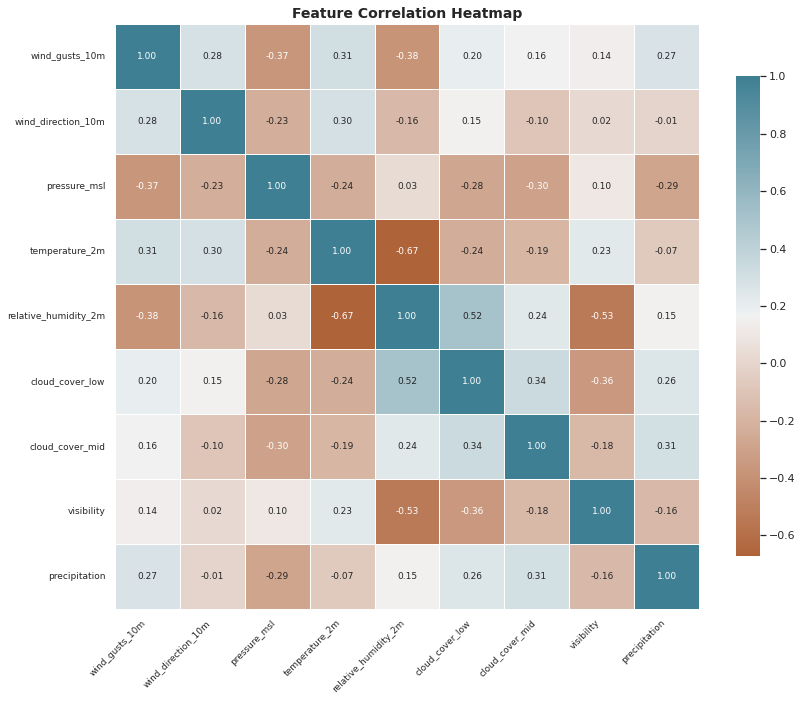

In [0]:
# correlation heatmap between selected features

feature_cols = [ 'wind_gusts_10m', 'wind_direction_10m', 'pressure_msl', 'temperature_2m', 'relative_humidity_2m','cloud_cover_low', 'cloud_cover_mid', 'visibility',  'precipitation', 'year', 'month', 'season', 'hour']

# convert Spark DataFrame to Pandas
pdf = sdf_merged.select(feature_cols).toPandas()

# correlation matrix
corr_matrix = pdf[['wind_gusts_10m', 'wind_direction_10m', 'pressure_msl', 'temperature_2m', 'relative_humidity_2m','cloud_cover_low', 'cloud_cover_mid', 'visibility',  'precipitation']].corr()

plt.figure(figsize=(12, 10))
sns.set(style="white")

# Color palette with orange and blue
cmap = sns.diverging_palette(30, 220, as_cmap=True)

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 9}
)

plt.title("Feature Correlation Heatmap", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()



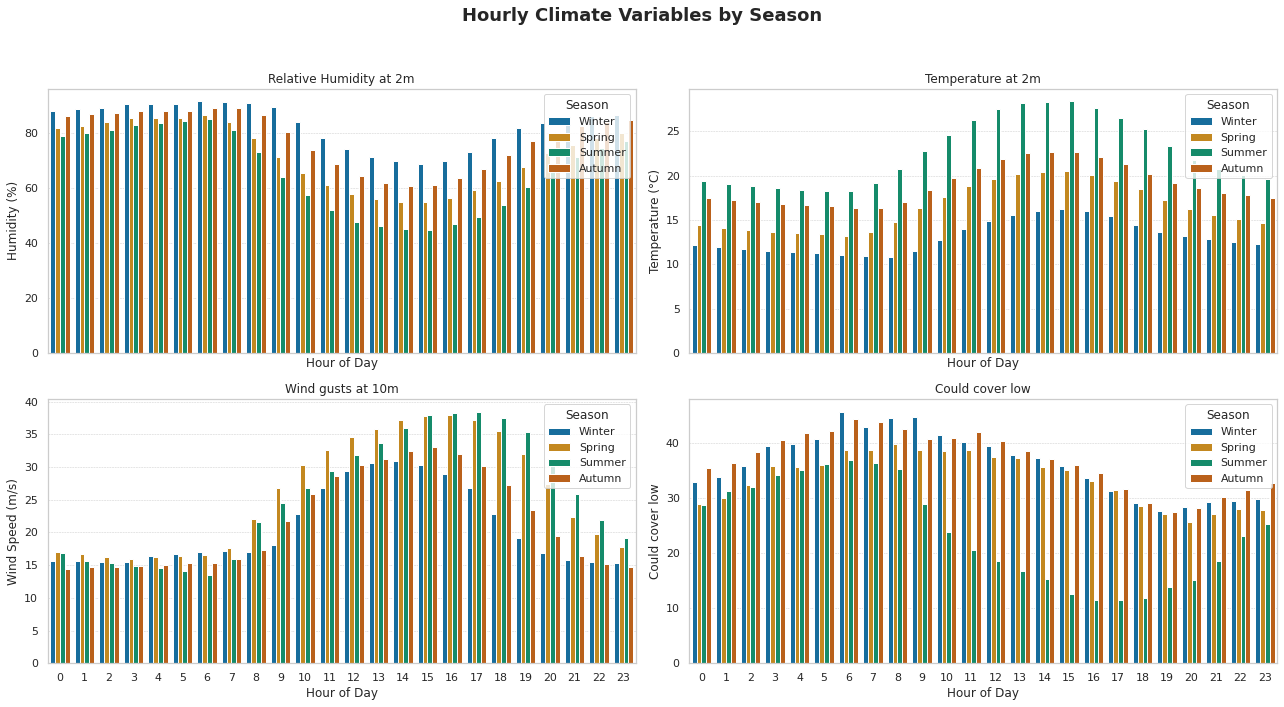

In [0]:
# Group and process data
grouped = pdf.groupby(['hour', 'season']).agg({
    'relative_humidity_2m': 'mean',
    'temperature_2m': 'mean',
    'wind_gusts_10m': 'mean',
    'cloud_cover_low': 'mean'
}).reset_index()

# Season order
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
grouped['season'] = pd.Categorical(grouped['season'], categories=season_order, ordered=True)

sns.set_theme(style='whitegrid')
palette = sns.color_palette("colorblind")


fig, axs = plt.subplots(2, 2, figsize=(18, 10), sharex=True)

# See the evolution of humidity, temperature, wind gusts and cloud cover across the hours of the day per season
sns.barplot(data=grouped, x='hour', y='relative_humidity_2m', hue='season', ax=axs[0, 0], palette=palette)
axs[0, 0].set_title('Relative Humidity at 2m')
axs[0, 0].set_ylabel('Humidity (%)')

sns.barplot(data=grouped, x='hour', y='temperature_2m', hue='season', ax=axs[0, 1], palette=palette)
axs[0, 1].set_title('Temperature at 2m')
axs[0, 1].set_ylabel('Temperature (°C)')

sns.barplot(data=grouped, x='hour', y='wind_gusts_10m', hue='season', ax=axs[1, 0], palette=palette)
axs[1, 0].set_title('Wind gusts at 10m')
axs[1, 0].set_ylabel('Wind Speed (m/s)')

sns.barplot(data=grouped, x='hour', y='cloud_cover_low', hue='season', ax=axs[1, 1], palette=palette)
axs[1, 1].set_title('Could cover low')
axs[1, 1].set_ylabel('Could cover low')

for ax in axs.flat:
    ax.set_xlabel('Hour of Day')
    ax.legend(title='Season', loc='upper right')
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

plt.suptitle('Hourly Climate Variables by Season', fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Export the dataframe

In [0]:
# Permanent table name
permanent_table_name = "historical_weather_hourly_lisbon"

# Try to delete managed table
try:
    dbutils.fs.rm("dbfs:/user/hive/warehouse/historical_weather_hourly_lisbon", recurse=True)
    print("Deleted successfully.")
except Exception as e:
    print("Path may not exist or could not be deleted:", str(e))
# Save as a managed table as parquet
sdf_merged.write.mode("overwrite").format("parquet").saveAsTable(permanent_table_name)

# Save used feature cols 
# TODO change tmp folder?
dbutils.fs.put("dbfs:/tmp/feature_cols.json", json.dumps(feature_cols), overwrite=True)

Deleted successfully.
Wrote 164 bytes.
Out[91]: True

In [0]:
# Load selected features
feature_cols_json = dbutils.fs.head("dbfs:/tmp/feature_cols.json")
feature_cols = json.loads(feature_cols_json)
feature_cols

Out[92]: ['wind_gusts_10m',
 'wind_direction_10m',
 'pressure_msl',
 'temperature_2m',
 'relative_humidity_2m',
 'cloud_cover',
 'cloud_cover_high',
 'visibility',
 'precipitation']

In [0]:
# Load data from DBFS
sdf = spark.table("historical_weather_hourly_lisbon")
display(sdf.limit(10))

time wind_speed_10m wind_speed_120m wind_direction_10m wind_direction_120m wind_gusts_10m cloud_cover cloud_cover_low cloud_cover_mid cloud_cover_high visibility apparent_temperature temperature_2m temperature_120m relative_humidity_2m dew_point_2m vapour_pressure_deficit precipitation rain showers snowfall snow_depth surface_pressure pressure_msl evapotranspiration et0_fao_evapotranspiration year month hour season day 2023-05-01T00:00 6.2 21.4 21 7 18.0 0 0 0 0 24140.0 16.3 16.6 16.2 73 11.8 0.51 0.0 0.0 0.0 0.0 0.0 1014.5 1018.3 0.01 0.01 2023 5 0 Spring 1 2023-05-01T01:00 4.5 19.8 14 2 13.0 0 0 0 0 24140.0 16.3 16.5 16.4 73 11.6 0.51 0.0 0.0 0.0 0.0 0.0 1014.2 1018.0 0.01 0.0 2023 5 1 Spring 1 2023-05-01T02:00 3.0 18.8 346 355 10.4 0 0 0 0 24140.0 16.1 16.3 16.7 69 10.6 0.58 0.0 0.0 0.0 0.0 0.0 1013.7 1017.5 0.01 0.0 2023 5 2 Spring 1 2023-05-01T03:00 3.2 18.8 360 357 6.8 100 0 0 100 24140.0 15.7 16.1 16.7 67 10.0 0.61 0.0 0.0 0.0 0.0 0.0 1013.7 1017.5 0.01 0.0 2023 5 3 Spring 1 2023-05-01T04:00 3.0 17.7 346 355 5.8 42 0 0 42 24140.0 15.6 16.1 16.7 66 9.7 0.62 0.0 0.0 0.0 0.0 0.0 1014.0 1017.8 0.01 0.0 2023 5 4 Spring 1 2023-05-01T05:00 3.6 19.4 6 360 8.3 96 0 0 96 24140.0 15.4 16.0 16.6 66 9.7 0.62 0.0 0.0 0.0 0.0 0.0 1014.0 1017.8 0.01 0.0 2023 5 5 Spring 1 2023-05-01T06:00 3.4 16.7 32 6 9.0 29 0 0 29 24140.0 15.3 15.8 16.6 68 9.9 0.58 0.0 0.0 0.0 0.0 0.0 1013.9 1017.7 0.01 0.03 2023 5 6 Spring 1 2023-05-01T07:00 3.3 14.5 41 14 7.2 0 0 0 0 24140.0 16.4 16.6 16.6 70 11.1 0.57 0.0 0.0 0.0 0.0 0.0 1014.0 1017.8 0.01 0.05 2023 5 7 Spring 1 2023-05-01T08:00 5.0 11.7 21 18 14.4 0 0 0 0 24140.0 18.5 19.0 16.9 59 10.8 0.9 0.0 0.0 0.0 0.0 0.0 1014.4 1018.2 0.04 0.17 2023 5 8 Spring 1 2023-05-01T09:00 7.0 9.2 21 21 19.4 0 0 0 0 24140.0 20.7 21.5 18.7 50 10.6 1.28 0.0 0.0 0.0 0.0 0.0 1014.5 1018.3 0.09 0.32 2023 5 9 Spring 1

## Conclusions

Perpectives and features to use for clustering:

- **1. Wind and Pressure:** _wind_gusts_10m_, _wind_direction_10m_, _pressure_msl_
- **2. Precipitation and visibility:** _cloud_cover_, _cloud_cover_high_, _visibility_, _precipitation_
- **3. Temperature and Humidity:** _temperature_2m_, _relative_humidity_2m_


Notes:
- Maybe join the wind perspective with temperature?? another possibility is to use different models for different type of anomalies. I would say that for the temperature/humidity the thersolds is the best. For the other perspectives we can use clusters adn try the 2 algorithms maybe. See the days where they overlap and the days where it is just one type of anomaly.